In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

In [ ]:
# Download latest version
path = kagglehub.dataset_download("krzysztofjamroz/apartment-prices-in-poland")

print("Path to dataset files:", path)

Path to dataset files: /home/ilyarekun/.cache/kagglehub/datasets/krzysztofjamroz/apartment-prices-in-poland/versions/9


In [5]:
%cp -r /home/ilyarekun/.cache/kagglehub/datasets/krzysztofjamroz/apartment-prices-in-poland/versions/9/ ./data

In [6]:
for filename in os.listdir("./data/9"):
    pd
    print(filename)


apartments_pl_2024_04.csv
apartments_pl_2024_05.csv
apartments_pl_2024_06.csv
apartments_pl_2023_08.csv
apartments_pl_2023_09.csv
apartments_pl_2023_10.csv
apartments_pl_2023_11.csv
apartments_pl_2023_12.csv
apartments_pl_2024_01.csv
apartments_pl_2024_02.csv
apartments_pl_2024_03.csv
apartments_rent_pl_2023_11.csv
apartments_rent_pl_2023_12.csv
apartments_rent_pl_2024_01.csv
apartments_rent_pl_2024_02.csv
apartments_rent_pl_2024_03.csv
apartments_rent_pl_2024_04.csv
apartments_rent_pl_2024_05.csv
apartments_rent_pl_2024_06.csv


In [7]:
df1 = pd.read_csv("./data/9/apartments_rent_pl_2024_01.csv")
df2 = pd.read_csv("./data/9/apartments_rent_pl_2024_02.csv")
df3 = pd.read_csv("./data/9/apartments_rent_pl_2024_03.csv")
df4 = pd.read_csv("./data/9/apartments_rent_pl_2024_04.csv")
df5 = pd.read_csv("./data/9/apartments_rent_pl_2024_05.csv")
df6 = pd.read_csv("./data/9/apartments_rent_pl_2024_06.csv")


df = pd.concat([df1,df2,df3,df4,df5,df6])
print(df.head())

                                 id      city          type  squareMeters  \
0  2a1a6db97ff122d6bc148abb6f0e498a  szczecin  blockOfFlats          52.0   
1  368e16142922433c709e6921a3b8f2a8  szczecin  blockOfFlats          70.0   
2  655acd54eb518a718fd1f59fd7161c61  szczecin  blockOfFlats          43.0   
3  99f85bbc55d110aa5a79ad4c7d5a0562  szczecin  blockOfFlats          46.7   
4  601b83a79fb6b89fe8e488bfcdd5e872  szczecin           NaN          56.2   

   rooms  floor  floorCount  buildYear   latitude  longitude  ...  \
0    2.0    3.0         3.0     2008.0  53.460535  14.545416  ...   
1    3.0    7.0        11.0     1985.0  53.378485  14.657089  ...   
2    2.0    3.0         3.0     1960.0  53.425946  14.559489  ...   
3    2.0    1.0         4.0     1980.0  53.446990  14.556851  ...   
4    3.0    1.0         4.0        NaN  53.441100  14.549100  ...   

   pharmacyDistance    ownership  buildingMaterial  condition  \
0             0.307  condominium             brick       

In [8]:
df['floor'].max()

np.float64(30.0)

In [9]:
# convert to numerical values
df['type_numerical'] = pd.factorize(df['type'])[0]
df['condition_numerical'] = pd.factorize(df['condition'])[0]
df['city_numerical'] = pd.factorize(df['city'])[0]

In [10]:
type_save = df['type'].unique()
condition_save = df['condition'].unique()
city_save = df['city'].unique()

idx_type = {}
idx_condition = {}
idx_city = {}

for type_str in type_save:
    for idx,el in df.iterrows():
        if el['type'] == type_str:
            idx_type[type_str] = el['type_numerical']
            break

for condition_str in condition_save:
    for idx,el in df.iterrows():
        if el['condition'] == condition_str:
            idx_condition[condition_str] = el['condition_numerical']
            break

for city_str in city_save:
    for idx,el in df.iterrows():
        if el['city'] == city_str:
            idx_city[city_str] = el['city_numerical']
            break
        
print(idx_type)
print(idx_condition)
print(idx_city)

{'blockOfFlats': 0, 'tenement': 1, 'apartmentBuilding': 2}
{'premium': 0, 'low': 1}
{'szczecin': 0, 'gdynia': 1, 'krakow': 2, 'poznan': 3, 'bialystok': 4, 'gdansk': 5, 'wroclaw': 6, 'radom': 7, 'rzeszow': 8, 'lodz': 9, 'katowice': 10, 'lublin': 11, 'czestochowa': 12, 'warszawa': 13, 'bydgoszcz': 14}


In [11]:
df = df.drop('type', axis=1)
df = df.drop('condition', axis=1)

df['hasElevator'].fillna('yes', inplace=True)

columns_to_change = ['hasParkingSpace', 'hasBalcony', 'hasSecurity','hasStorageRoom','hasElevator']
maping = {'yes': 1, 'no': 0}
df[columns_to_change] = df[columns_to_change].applymap(lambda x: maping.get(x, x))
df=df.drop('id', axis=1)


# removing rare, unimportant columns
rare_columns = ['buildYear', 'buildingMaterial','condition_numerical',
                'schoolDistance', 'clinicDistance','kindergartenDistance','restaurantDistance','collegeDistance',
                'pharmacyDistance','postOfficeDistance','ownership']
df.drop(columns=rare_columns, inplace=True)


# null values
median_type = df['type_numerical'].median()
median_floor = df['floor'].median()
median_floorCount = df['floorCount'].median()

df['type_numerical'].fillna(median_type, inplace=True)
df['floor'].fillna(median_floor, inplace=True)
df['floorCount'].fillna(median_floorCount, inplace=True)

#price column moved to the end
temp_column = df.pop('price')
df['price'] = temp_column

#removing outliers
Q1 = np.percentile(df['price'], 25)
Q3 = np.percentile(df['price'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound)&(df['price'] <= upper_bound)]

df.head()

/tmp/ipykernel_89606/764063362.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hasElevator'].fillna('yes', inplace=True)
/tmp/ipykernel_89606/764063362.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_change] = df[columns_to_change].applymap(lambda x: maping.get(x, x))
/tmp/ipykernel_89606/764063362.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pan

,city,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical,price
0,szczecin,52.0,2.0,3.0,3.0,53.460535,14.545416,4.26,2.0,1,1,0,0,0,0,0,3500
1,szczecin,70.0,3.0,7.0,11.0,53.378485,14.657089,8.10,21.0,0,1,1,0,0,0,0,2900
2,szczecin,43.0,2.0,3.0,3.0,53.425946,14.559489,0.30,68.0,0,1,0,0,1,0,0,2900
3,szczecin,46.7,2.0,1.0,4.0,53.446990,14.556851,2.64,14.0,0,0,0,0,1,0,0,2400
4,szczecin,56.2,3.0,1.0,4.0,53.441100,14.549100,2.12,24.0,0,0,1,0,0,-1,0,3000


In [12]:
df.describe()

,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical,price
count,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000,49230.000000
mean,50.813336,2.246374,3.296567,5.616169,51.717221,19.590314,3.859642,24.236908,0.394516,0.614544,0.669592,0.142088,0.160553,0.511213,7.925899,3268.852651
std,17.290757,0.738474,2.396837,3.364620,1.217520,1.689265,2.582713,26.706986,0.488751,0.486708,0.470365,0.349144,0.367121,1.161319,4.715527,1250.192002
min,25.000000,1.000000,1.000000,1.000000,49.982150,14.447100,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,346.000000
25%,38.700000,2.000000,2.000000,4.000000,50.276728,18.600124,1.790000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2400.000000
50%,48.000000,2.000000,3.000000,5.000000,52.167442,19.941133,3.420000,16.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,9.000000,3000.000000
75%,59.000000,3.000000,4.000000,7.000000,52.252300,20.993450,5.420000,29.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,13.000000,3950.000000
max,150.000000,6.000000,30.000000,30.000000,54.573680,23.199087,16.620000,210.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,14.000000,7000.000000


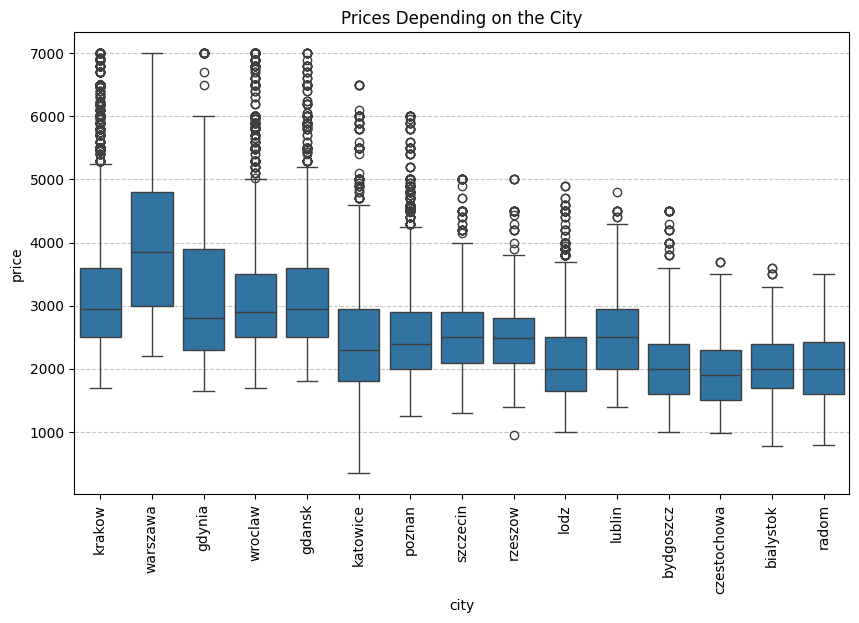

In [13]:
df_sorted = df.sort_values(by='price', ascending=False)
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='price', data=df_sorted)

plt.xlabel('city')
plt.ylabel('price')
plt.title('Prices Depending on the City')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

In [14]:
df=df.drop('city',axis=1)

In [15]:
df.head()

,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical,price
0,52.0,2.0,3.0,3.0,53.460535,14.545416,4.26,2.0,1,1,0,0,0,0,0,3500
1,70.0,3.0,7.0,11.0,53.378485,14.657089,8.10,21.0,0,1,1,0,0,0,0,2900
2,43.0,2.0,3.0,3.0,53.425946,14.559489,0.30,68.0,0,1,0,0,1,0,0,2900
3,46.7,2.0,1.0,4.0,53.446990,14.556851,2.64,14.0,0,0,0,0,1,0,0,2400
4,56.2,3.0,1.0,4.0,53.441100,14.549100,2.12,24.0,0,0,1,0,0,-1,0,3000


In [16]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
rf_model = RandomForestRegressor(
    n_estimators=500,          # Увеличиваем число деревьев
    max_depth=30,              # Увеличиваем глубину
    max_features='sqrt',       # Пробуем log2 вместо sqrt
    random_state=42,
    n_jobs=-1                  # Используем все ядра процессора
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [18]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MSE: 164285.32084398702
MAE: 263.8455760953535
R-squared: 0.893913881869902
RMSE: 405.32125634364036
MAPE: 8.51218291064875


In [ ]:
joblib.dump(rf_model, './backend/random_forest_model.pkl')

['./data/random_forest_model.pkl']

In [20]:
a = X.iterrows()
print(next(a))
X.head()

(0, squareMeters       52.000000
rooms               2.000000
floor               3.000000
floorCount          3.000000
latitude           53.460535
longitude          14.545416
centreDistance      4.260000
poiCount            2.000000
hasParkingSpace     1.000000
hasBalcony          1.000000
hasElevator         0.000000
hasSecurity         0.000000
hasStorageRoom      0.000000
type_numerical      0.000000
city_numerical      0.000000
Name: 0, dtype: float64)


,squareMeters,rooms,floor,floorCount,latitude,longitude,centreDistance,poiCount,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,type_numerical,city_numerical
0,52.0,2.0,3.0,3.0,53.460535,14.545416,4.26,2.0,1,1,0,0,0,0,0
1,70.0,3.0,7.0,11.0,53.378485,14.657089,8.10,21.0,0,1,1,0,0,0,0
2,43.0,2.0,3.0,3.0,53.425946,14.559489,0.30,68.0,0,1,0,0,1,0,0
3,46.7,2.0,1.0,4.0,53.446990,14.556851,2.64,14.0,0,0,0,0,1,0,0
4,56.2,3.0,1.0,4.0,53.441100,14.549100,2.12,24.0,0,0,1,0,0,-1,0


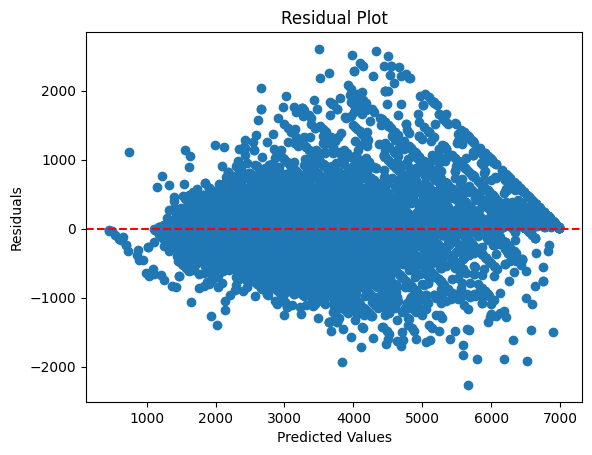

In [21]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

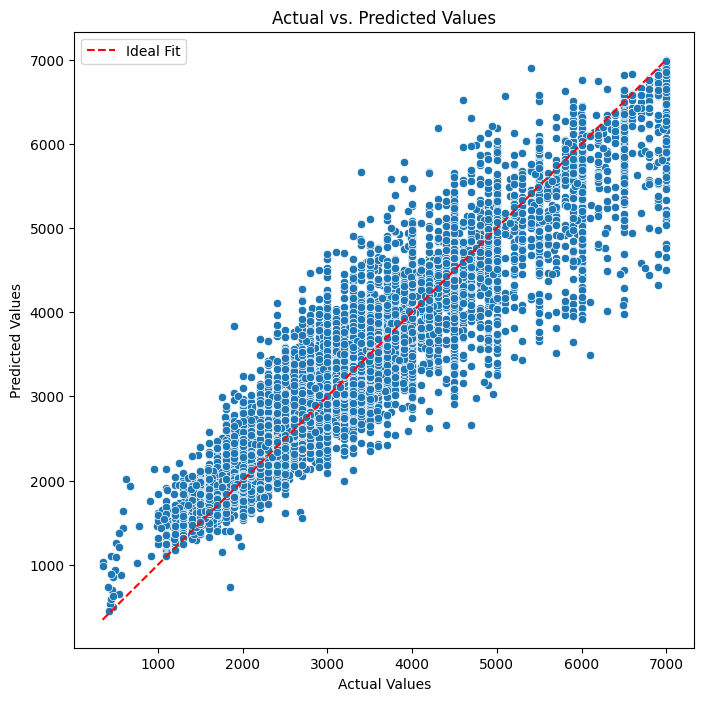

In [22]:
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot(ideal_line, ideal_line, '--', color='red', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

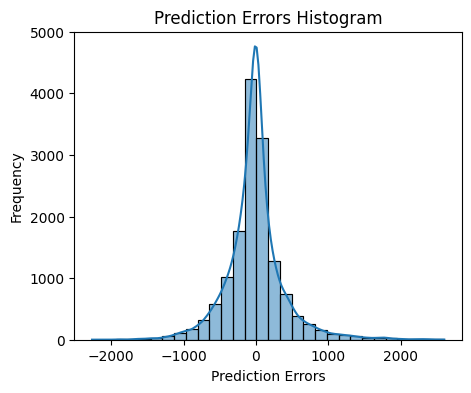

In [23]:
errors = y_test - y_pred

plt.figure(figsize=(5, 4))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Prediction Errors Histogram')
plt.show()

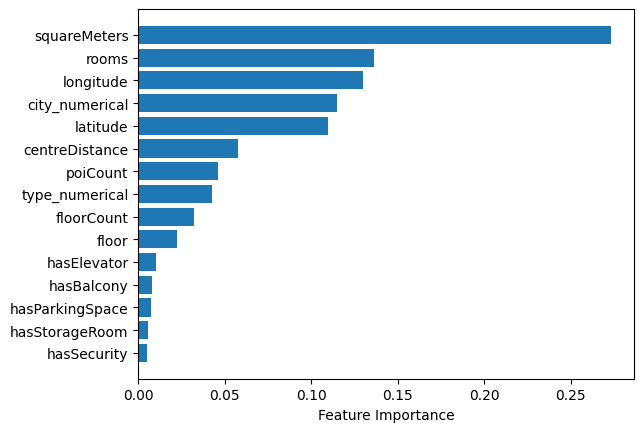

In [24]:
feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

In [25]:
# used parameters
params = rf_model.get_params()

print("Random Forest model parameters:")
for param, value in params.items():
    print(f"{param}: {value}")

Random Forest model parameters:
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: 30
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 500
n_jobs: -1
oob_score: False
random_state: 42
verbose: 0
warm_start: False
